# Dice and IOU for rotated shapes

## Context
In Machine learning, the Dice and IOU (Intersection over Union) metrics are often used to calculate the accuracy of predictions.

For object detection, they are commonly used to compute the accuracy of the predicted bounding boxes vs the labeled boxes. These boxes are typically not rotated. 

But when shapes are rotated like they are in the context of my app **Mix on Pix**, then it can be more complicated to
calculated the area of a shape or the area of the intersection of shapes.


Here we use the python **shapely** package to calculate the area of shapes and their intersections.

In [1]:
from platform import python_version

print(python_version())

3.9.13


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from six.moves import cPickle as pickle
from shapely.geometry import Polygon

import os

In [3]:
IMAGE_SIZE = 70 # images are 70px x 70px

In [4]:
# Plot utility function
def plot_sample(X, y, pred, axs):
   
    axs.imshow(X.reshape(IMAGE_SIZE,   IMAGE_SIZE),cmap="gray")
    axs.scatter(IMAGE_SIZE*y[0::2],    IMAGE_SIZE*y[1::2],c='orange')
    axs.scatter(IMAGE_SIZE*pred[0::2], IMAGE_SIZE*pred[1::2],c='green')

## Calculate Accuracy with Dice and IOU
- We create polygons using the real vertices (angular points) and predicted vertices.
- 100% accuracy occurs when real polygon and predicted polygon exactly share the same area.

In [5]:
# IoU = |A∩B| / |A∪B| = |I| / |U|
def calculate_IOU(label, pred, nb_vertices=4):
    
    y_polygon   = Polygon(label.reshape(nb_vertices, 2))
    pred_polygon= Polygon(pred.reshape(nb_vertices, 2))

    I = y_polygon.intersection(pred_polygon).area
    U = y_polygon.area + pred_polygon.area - I
    IOU = I / U
    return IOU  

#
# Dice = 2 * |A∩B| / (|A| + |B|)
def calculate_Dice(label, pred, nb_vertices=4):
    
    y_polygon   = Polygon(label.reshape(nb_vertices, 2))
    pred_polygon= Polygon(pred.reshape(nb_vertices, 2))

    I = y_polygon.intersection(pred_polygon).area
    dice = 2 * I / (y_polygon.area + pred_polygon.area) 
    return dice

## Calculate with data extracted from Mix on Pix validation set

In [6]:
with open("data/vertices.pickle", 'rb') as f:
    data_pickle = pickle.load(f)

In [7]:
real_images   = data_pickle['real_images']
real_vertices = data_pickle['real_vertices']
pred_vertices = data_pickle['pred_vertices']

In [8]:
# These coordinates:
# - Have the form: [x1,y1, x2,y2, x3,y3, x4,y4] where (0,0) is top-left and (1,1) is bottom-right
# - Are always ordered clockwize (this is important to correctly compute the shape area).
print("real_vertices:", real_vertices[0])
print("pred_vertices:", pred_vertices[0])


real_vertices: [0.8  0.8  0.13 0.32 0.26 0.13 0.88 0.63]
pred_vertices: [0.7700848  0.7833768  0.13342288 0.3256822  0.24662682 0.1621575
 0.8848326  0.62041795]


## Show Dice and IOU for a few images

- The white lines are the user drawing
- The **orange** dots represent the **labeled** position of the vertices
- The **green** dots represent the **predicted** position of the vertices

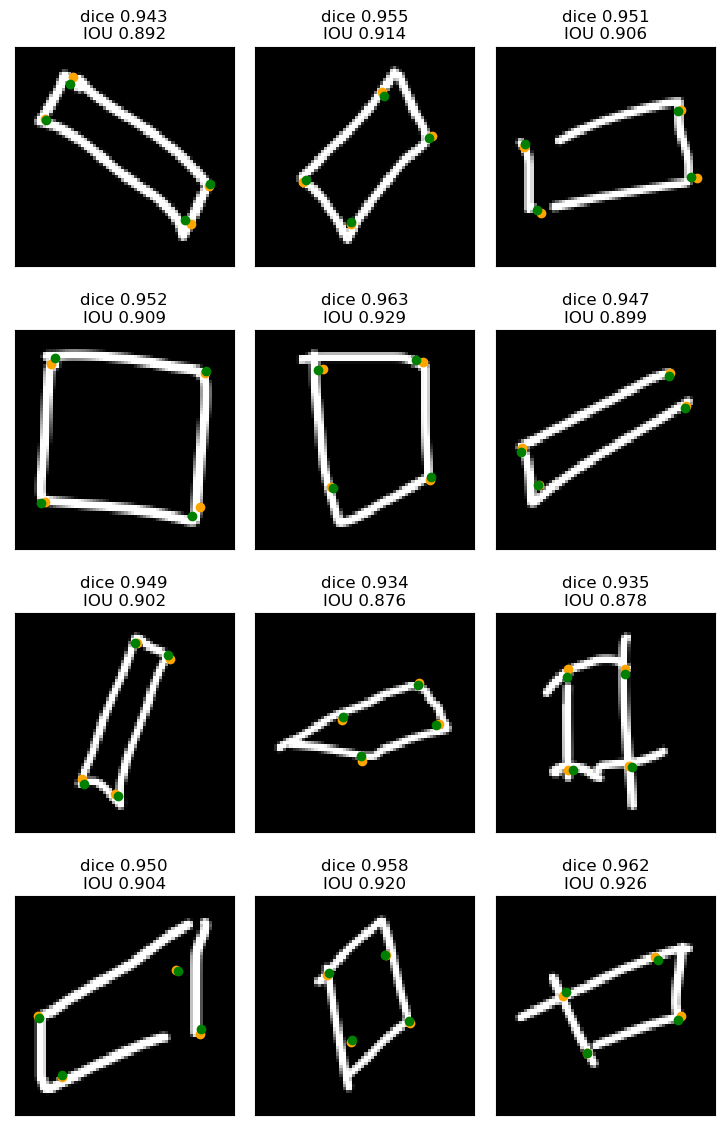

In [9]:
fig = plt.figure(figsize=(7, 11))
fig.subplots_adjust(hspace=0.13,wspace=0.1,
                    left=0,right=1,bottom=0, top=1)
nb_pictures = len(real_images)

for i in range(nb_pictures):
    ax = fig.add_subplot(nb_pictures//3 , 3, i+1, xticks=[], yticks=[])        
    plot_sample(real_images[i], real_vertices[i], pred_vertices[i], ax)
    
    dice = calculate_Dice(real_vertices[i], pred_vertices[i], nb_vertices=4)
    IOU  = calculate_IOU(real_vertices[i], pred_vertices[i], nb_vertices=4)
    
    ax.set_title("dice {:5.3f}\nIOU {:5.3f}".format(dice, IOU))
plt.show()